In [1]:
%matplotlib inline

In [2]:
# Advantage Actor Critic (A2C) implementation
# my notes on the theory: https://till2.github.io/blog/2022/12/15/actorcritic 

In [12]:
import gymnasium as gym
from gymnasium.utils.play import play

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import os

In [3]:
class A2C(nn.Module):

    def __init__(self, n_features:int, n_actions: int, device: torch.device, 
                 critic_lr: float, actor_lr: float) -> None:
        """ Initializes the actor and critic networks and the respective optimizers. """
        super(A2C, self).__init__()
        self.device = device
        
        critic_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32,32),
            nn.ReLU(),
            nn.Linear(32, 1), # estimate V(s)
        ]

        actor_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32,32),
            nn.ReLU(),
            nn.Linear(32, n_actions), # estimate action logits (will be fed into a softmax later)
        ]

        # define actor and critic networks
        self.critic = nn.Sequential(*critic_layers).to(self.device)
        self.actor = nn.Sequential(*actor_layers).to(self.device)

        # define optimizers for actor and critic
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=actor_lr)
    
    def forward(self, x:np.ndarray) -> tuple[torch.Tensor, torch.Tensor]:
        x = torch.Tensor(x).to(self.device)
        state_value = self.critic(x)
        action_logits = self.actor(x)
        return (state_value, action_logits)
    
    def select_action(self, x:np.ndarray) -> tuple[int, torch.Tensor, torch.Tensor]:
        """ Returns a tuple of the chosen action and the log-prob of that action. """
        state_value, action_logits = self.forward(x)
        action_pd = torch.distributions.Categorical(logits=action_logits) # implicitly uses softmax
        action = action_pd.sample()
        action_log_prob = action_pd.log_prob(action)
        return (action.item(), action_log_prob[0], state_value[0][0])
    
    def get_losses(self, rewards: list, action_log_probs: list[torch.Tensor], 
                   value_preds: list[torch.Tensor], 
                   gamma: float, lam: float, device:torch.device) -> tuple[torch.Tensor, torch.Tensor]:
        """ Computes the loss for one episode for actor and critic. """
        # convert arrays to PyTorch tensors
        action_log_probs = torch.stack(action_log_probs).to(device)
        value_preds = torch.stack(value_preds).to(device)                

        # calculate the returns efficiently (in reverse, from T..0).
        T = len(rewards)
        returns = torch.zeros(T, device=device) # these are the observed state_action_values (Q-vals)
        
        future_return = 0.0
        for t in reversed(range(T)):
            future_return = rewards[t] + gamma * future_return
            returns[t] = future_return

        # calculate the loss of the episode for the critic
        critic_loss = sum((returns - value_preds)**2)

        # calculate the advantages
        advantages = returns - value_preds.detach()
        
        # calculate the loss of the episode for the actor
        actor_loss = - torch.dot(advantages, action_log_probs)

        return (actor_loss, critic_loss)
    
    def update_critic(self, critic_loss: torch.Tensor) -> None:
        """ Updates the parameters of the critic network according to the given loss. """
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

    def update_actor(self, actor_loss: torch.Tensor) -> None:
        """ Updates the parameters of the actor network according to the given loss. """
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

In [6]:
# hyperparams
env_name = 'LunarLander-v2'
n_episodes = 10_000
gamma = 0.99
lam = 0.9
critic_lr = 0.001
actor_lr = 0.001

# environment setup
env = gym.make(env_name, max_episode_steps=600)
obs_shape = env.observation_space.shape[0]
action_shape = env.action_space.n
print('obs_shape:', obs_shape)
print('action_shape:', action_shape)

# set the device (here to cpu)
device = torch.device('cpu') # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using device: {device}')
if device.type == 'cuda':
    print(torch.cuda.get_device_name())

# init the agent
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr)
print(f'Training {agent.__class__.__name__} in the {env_name} environment...')
print(agent)

obs_shape: 8
action_shape: 4
using device: cpu
Training A2C in the LunarLander-v2 environment...
A2C(
  (critic): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


In [5]:
# create a wrapper environment to save episode returns and episode lenghts
wrapper_env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

critic_losses = []
actor_losses = []
mean_advantages = []

# use tqdm to get a progress bar for training
for episode in tqdm(range(n_episodes)): 
    
    # reset everything
    rewards = []
    value_preds = []
    action_log_probs = []
    done = False
    
    # get an initial state
    state, info = wrapper_env.reset()

    # play one episode
    while not done:
        
        # select an action A_{t} using S_{t} as input for the agent
        action, action_log_prob, state_value_pred = agent.select_action(state[None, :])
        
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = wrapper_env.step(action)
        
        value_preds.append(state_value_pred)
        action_log_probs.append(action_log_prob)
        rewards.append(reward)

        # update if the environment is done
        done = terminated or truncated      
        
    
    # calculate the losses for actor and critic
    actor_loss, critic_loss = agent.get_losses(rewards, action_log_probs, value_preds, gamma, lam, device)   
    
    # update the actor and critic networks
    agent.update_critic(critic_loss)
    agent.update_actor(actor_loss)
    
    # log manually
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())
    

obs_shape: 8
action_shape: 4
using device: cpu
Training A2C in the LunarLander-v2 environment...
A2C(
  (critic): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


100%|█████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [30:07<00:00,  5.53it/s]


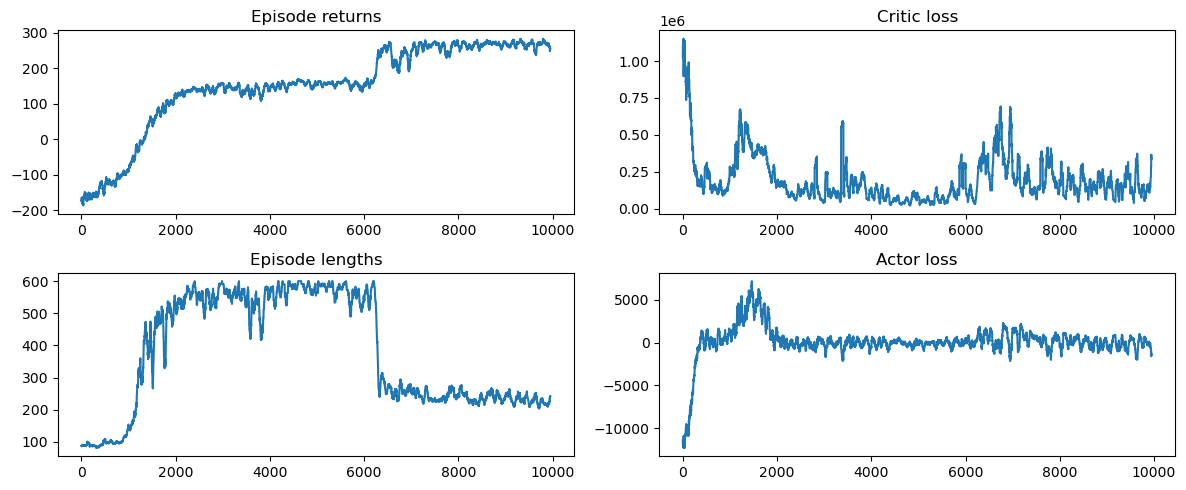

In [6]:
""" plot the results """

rolling_length = 50
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))

# episode return
axs[0][0].set_title("Episode returns")
episode_returns_moving_average = (
    np.convolve(
        np.array(wrapper_env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][0].plot(episode_returns_moving_average)

# episode length
axs[1][0].set_title("Episode lengths")
episode_length_moving_average = (
    np.convolve(np.array(wrapper_env.length_queue), np.ones(rolling_length), mode="valid")
    / rolling_length)
axs[1][0].plot(episode_length_moving_average)

# critic loss
axs[0][1].set_title("Critic loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)

# actor loss
axs[1][1].set_title("Actor loss")
actor_losses_moving_average = (
    np.convolve(
        np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)

plt.tight_layout()
plt.show()

In [10]:
save_weights = False
load_weights = True

actor_weights_path = 'weights/actor_weights.h5'
critic_weights_path = 'weights/critic_weights.h5'
if not os.path.exists('weights'):
    os.mkdir('weights')

""" save network weights """
if save_weights:
    torch.save(agent.actor.state_dict(), actor_weights_path)
    torch.save(agent.critic.state_dict(), critic_weights_path)

    
""" load network weights """
if load_weights:
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr)
    
    agent.actor.load_state_dict(torch.load(actor_weights_path))
    agent.critic.load_state_dict(torch.load(critic_weights_path))
    agent.actor.eval()
    agent.critic.eval();

In [16]:
""" play a couple of showcase episodes """

n_showcase_episodes = 20
env = gym.make(env_name, render_mode='human', max_episode_steps=350)

for episode in range(n_showcase_episodes): 
    print('starting episode', episode, '...')
    done = False
    
    # get an initial state
    state, info = env.reset()

    # play one episode
    while not done:
        
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _ = agent.select_action(state[None, :])
        
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action)

        # update if the environment is done
        done = terminated or truncated    

env.close()

starting episode 0 ...
starting episode 1 ...
starting episode 2 ...
starting episode 3 ...
starting episode 4 ...
starting episode 5 ...
starting episode 6 ...
starting episode 7 ...
starting episode 8 ...
starting episode 9 ...
starting episode 10 ...
starting episode 11 ...
starting episode 12 ...
starting episode 13 ...
starting episode 14 ...
starting episode 15 ...
starting episode 16 ...
starting episode 17 ...
starting episode 18 ...
starting episode 19 ...


In [15]:
""" try the environment yourself """

play(gym.make("LunarLander-v2", render_mode="rgb_array"), keys_to_action={"w": 2, "a": 1, "d": 3}, noop=0)